In [0]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
N_FACE = 70
N_POSE = 8
FOLDER = './drive/My Drive/636/data/json/'
CSV_FOLDER = './drive/My Drive/636/data/csv/'

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

Reshape Data into Segments and Prepare for Keras (part5 data)

In [0]:
# dataset = pd.read_csv('./drive/My Drive/636/dataset/part4/dataset.csv')

In [0]:
file_path = './drive/My Drive/636/dataset/part5/dataset_dropped.csv'
dataset = pd.read_csv(file_path)

In [0]:
dataset.head()

,Unnamed: 0,vid,label,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,...,f_116,f_117,f_118,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_126,f_127,f_128,f_129,f_130,f_131,f_132,f_133,f_134,f_135,f_136,f_137,f_138,f_139,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,p_12,p_13,p_14,p_15
0,0,12,0,0.321038,0.501176,0.309984,0.691371,0.309984,0.774445,0.329636,0.844402,0.350515,0.903428,0.370167,0.953709,0.389818,0.975571,0.411926,0.975571,0.409469,0.975571,0.607212,0.953709,0.609668,0.975571,0.631776,0.925289,0.655112,0.877194,0.675992,0.807237,0.695643,0.730722,0.709153,0.652021,0.715294,0.571133,0.377536,0.505549,0.410698,...,0.489303,0.975571,0.459826,0.940592,0.440175,0.907800,0.494216,0.934034,0.517552,0.947151,0.538432,0.936220,0.577735,0.931848,0.538432,0.938406,0.517552,0.944965,0.492988,0.938406,0.430349,0.590808,0.630548,0.599553,0.531960,0.756189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,12,0,0.285971,0.550667,0.285971,0.656529,0.283268,0.747954,0.319763,0.827351,0.349501,0.904341,0.373831,0.959678,0.415734,1.000580,0.444120,1.000580,0.506298,1.000580,0.560366,1.000580,0.592806,1.000580,0.622544,0.935618,0.648226,0.873064,0.676611,0.793667,0.694183,0.714271,0.709052,0.630063,0.710404,0.550667,0.372480,0.500142,0.403569,...,0.484671,0.976519,0.460340,0.942836,0.440065,0.899529,0.491429,0.928400,0.513056,0.938024,0.536035,0.935618,0.573882,0.918777,0.536035,0.935618,0.513056,0.938024,0.491429,0.933212,0.426548,0.589162,0.625247,0.591568,0.524355,0.747948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,12,0,0.285893,0.478810,0.281725,0.577716,0.281725,0.691457,0.302563,0.782945,0.337292,0.876906,0.365076,0.946140,0.403972,1.015370,0.434534,1.015370,0.505382,1.015370,0.558170,1.015370,0.588732,0.990647,0.619294,0.933776,0.648466,0.869488,0.672082,0.792836,0.692919,0.711239,0.705422,0.627169,0.708200,0.548044,0.370632,0.496119,0.402583,...,0.483155,0.975811,0.458150,0.946140,0.438702,0.894214,0.490101,0.926359,0.510938,0.931304,0.535943,0.928831,0.572062,0.913995,0.535943,0.931304,0.510938,0.936249,0.490101,0.928831,0.426199,0.577716,0.623461,0.585134,0.519761,0.742567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,12,0,0.312792,0.483795,0.312792,0.399218,0.301827,0.752708,0.314010,0.815598,0.340815,0.884995,0.361527,0.932705,0.382240,0.958729,0.371274,0.934874,0.402952,0.958729,0.605203,0.937043,0.601548,0.958729,0.623479,0.915356,0.645410,0.863309,0.667340,0.793912,0.686834,0.720178,0.703892,0.639938,0.711202,0.568373,0.370056,0.494639,0.401734,...,0.484583,0.958729,0.456561,0.924031,0.438285,0.893670,0.488239,0.917525,0.508951,0.930537,0.533319,0.919694,0.569870,0.913188,0.532100,0.921862,0.510169,0.928368,0.488239,0.919694,0.423665,0.574879,0.623479,0.581385,0.519765,0.734375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,12,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.519762,0.731714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
dataset.shape

(97069, 159)

In [0]:
# get number of features
N_FEATURES = (N_FACE + N_POSE) * 2

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[3:]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
X = create_segments(dataset, 10)

In [0]:
y = dataset['label'].to_numpy()

In [0]:
print(X.shape, y.shape)

(97069, 10, 156) (97069,)


In [0]:
type(X)

numpy.ndarray

In [0]:
type(y)

numpy.ndarray

In [0]:
def save_3d(data):
  # Write the array to disk
  with open('./drive/My Drive/636/dataset/part5/sliced.txt', 'w') as outfile:
      # I'm writing a header here just for the sake of readability
      # Any line starting with "#" will be ignored by numpy.loadtxt
      outfile.write('# Array shape: {0}\n'.format(data.shape))

      # Iterating through a ndimensional array produces slices along
      # the last axis. This is equivalent to data[i,:,:] in this case
      for data_slice in data:

          # The formatting string indicates that I'm writing out
          # the values in left-justified columns 7 characters in width
          # with 2 decimal places.  
          # np.savetxt(outfile, data_slice, fmt='%-7.2f')
          np.savetxt(outfile, data_slice)

          # Writing out a break to indicate different slices...
          outfile.write('# New slice\n')

In [0]:
def read_3d(data):
  # Read the array from disk
  new_data = np.loadtxt('./drive/My Drive/636/dataset/part5/sliced.txt')

  # Note that this returned a 2D array!
  print new_data.shape

  # However, going back to 3D is easy if we know the 
  # original shape of the array
  new_data = new_data.reshape((97069, 50, 156))

  # Just to check that they're the same...
  assert np.all(new_data == data)

In [0]:
save_3d(X)

Create train and test set

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(77655, 10, 156) (19414, 10, 156) (77655,) (19414,)


In [0]:
print(type(X_train), type(y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Build model

**model1**

In [0]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, LSTM, Dropout, Flatten, Bidirectional
from keras.callbacks import History, EarlyStopping

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
def create_model():
  model = Sequential()
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
model = create_model()
history = model.fit(X_train, y_train, epochs=30, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 62124 samples, validate on 15531 samples
Epoch 1/30





 - 54s - loss: 0.5632 - acc: 0.7072 - val_loss: 0.5359 - val_acc: 0.7345
Epoch 2/30
 - 45s - loss: 0.4903 - acc: 0.7717 - val_loss: 0.4449 - val_acc: 0.8028
Epoch 3/30
 - 46s - loss: 0.4557 - acc: 0.7920 - val_loss: 0.4935 - val_acc: 0.7599
Epoch 4/30
 - 46s - loss: 0.4290 - acc: 0.8075 - val_loss: 0.4150 - val_acc: 0.8220
Epoch 5/30
 - 47s - loss: 0.4058 - acc: 0.8205 - val_loss: 0.4098 - val_acc: 0.8059
Epoch 6/30
 - 46s - loss: 0.3873 - acc: 0.8284 - val_loss: 0.3694 - val_acc: 0.8392
Epoch 7/30
 - 47s - loss: 0.3696 - acc: 0.8385 - val_loss: 0.3580 - val_acc: 0.8360
Epoch 8/30
 - 46s - loss: 0.3592 - acc: 0.8420 - val_loss: 0.4587 - val_acc: 0.8040
Epoch 9/30
 - 46s - loss: 0.3491 - acc: 0.8479 - val_los

In [0]:
history1 = model.fit(X_train, y_train, epochs=20, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)

Train on 62124 samples, validate on 15531 samples
Epoch 1/20
 - 46s - loss: 0.2253 - acc: 0.9048 - val_loss: 0.2375 - val_acc: 0.8994
Epoch 2/20
 - 47s - loss: 0.2266 - acc: 0.9034 - val_loss: 0.3130 - val_acc: 0.8644
Epoch 3/20
 - 47s - loss: 0.2220 - acc: 0.9082 - val_loss: 0.2609 - val_acc: 0.8891
Epoch 4/20
 - 45s - loss: 0.2177 - acc: 0.9082 - val_loss: 0.2194 - val_acc: 0.9057
Epoch 5/20
 - 47s - loss: 0.2151 - acc: 0.9096 - val_loss: 0.2208 - val_acc: 0.9072
Epoch 6/20
 - 46s - loss: 0.2132 - acc: 0.9110 - val_loss: 0.2504 - val_acc: 0.8894
Epoch 7/20
 - 47s - loss: 0.2116 - acc: 0.9113 - val_loss: 0.2383 - val_acc: 0.9034
Epoch 8/20
 - 46s - loss: 0.2085 - acc: 0.9120 - val_loss: 0.2200 - val_acc: 0.9089
Epoch 9/20
 - 46s - loss: 0.2070 - acc: 0.9134 - val_loss: 0.2615 - val_acc: 0.8895
Epoch 10/20
 - 47s - loss: 0.2041 - acc: 0.9147 - val_loss: 0.2236 - val_acc: 0.9041
Epoch 11/20
 - 47s - loss: 0.2038 - acc: 0.9140 - val_loss: 0.3063 - val_acc: 0.8645
Epoch 12/20
 - 47s - los

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               113152    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 113,281
Trainable params: 113,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
score

[0.22209378914698227, 0.9031111568786634]

In [0]:
score1 = model.evaluate(X_test, y_test, verbose=2)
score1

[0.3043228929506046, 0.8796229525392009]

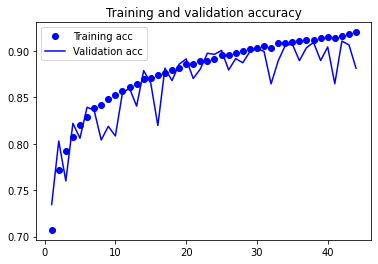

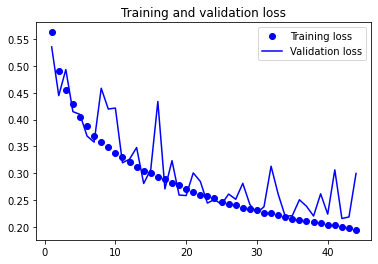

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc'] + history1.history['acc']
val_acc = history.history['val_acc'] + history1.history['val_acc']
loss = history.history['loss'] + history1.history['loss']
val_loss = history.history['val_loss'] + history1.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**model2**

In [0]:
def create_model():
  model = Sequential()

  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

# create model
model = create_model()

In [0]:
history = model.fit(X_train, y_train, epochs=50, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)
model.summary()

Train on 62124 samples, validate on 15531 samples
Epoch 1/30
 - 51s - loss: 0.5650 - acc: 0.7082 - val_loss: 0.5077 - val_acc: 0.7473
Epoch 2/30
 - 49s - loss: 0.4919 - acc: 0.7686 - val_loss: 0.4528 - val_acc: 0.7794
Epoch 3/30
 - 49s - loss: 0.4561 - acc: 0.7891 - val_loss: 0.4130 - val_acc: 0.8121
Epoch 4/30
 - 49s - loss: 0.4201 - acc: 0.8100 - val_loss: 0.3885 - val_acc: 0.8186
Epoch 5/30
 - 49s - loss: 0.3927 - acc: 0.8244 - val_loss: 0.3897 - val_acc: 0.8251
Epoch 6/30
 - 49s - loss: 0.3747 - acc: 0.8342 - val_loss: 0.3423 - val_acc: 0.8481
Epoch 7/30
 - 49s - loss: 0.3541 - acc: 0.8441 - val_loss: 0.3330 - val_acc: 0.8508
Epoch 8/30
 - 50s - loss: 0.3378 - acc: 0.8518 - val_loss: 0.3371 - val_acc: 0.8443
Epoch 9/30
 - 51s - loss: 0.3259 - acc: 0.8567 - val_loss: 0.3347 - val_acc: 0.8500
Epoch 10/30
 - 51s - loss: 0.3139 - acc: 0.8627 - val_loss: 0.3084 - val_acc: 0.8694
Epoch 11/30
 - 51s - loss: 0.3110 - acc: 0.8637 - val_loss: 0.2915 - val_acc: 0.8696
Epoch 12/30
 - 51s - los

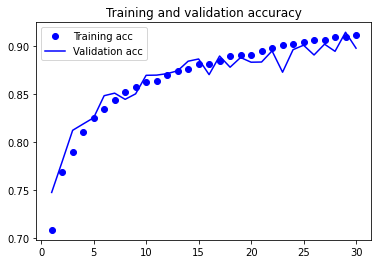

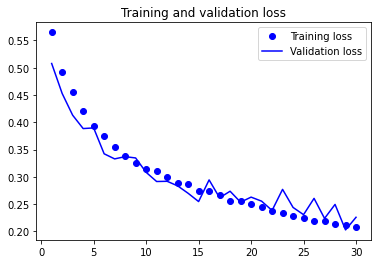

In [0]:
draw(history)

In [0]:
history1 = model.fit(X_train, y_train, epochs=20, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)

Train on 62124 samples, validate on 15531 samples
Epoch 1/20
 - 48s - loss: 0.2057 - acc: 0.9124 - val_loss: 0.2203 - val_acc: 0.9078
Epoch 2/20
 - 48s - loss: 0.2021 - acc: 0.9140 - val_loss: 0.2311 - val_acc: 0.9021
Epoch 3/20
 - 48s - loss: 0.2039 - acc: 0.9126 - val_loss: 0.2261 - val_acc: 0.8988
Epoch 4/20
 - 49s - loss: 0.1956 - acc: 0.9173 - val_loss: 0.2239 - val_acc: 0.9118
Epoch 5/20
 - 49s - loss: 0.1935 - acc: 0.9170 - val_loss: 0.2077 - val_acc: 0.9167
Epoch 6/20
 - 48s - loss: 0.1904 - acc: 0.9203 - val_loss: 0.2063 - val_acc: 0.9079
Epoch 7/20
 - 48s - loss: 0.1893 - acc: 0.9200 - val_loss: 0.2071 - val_acc: 0.9097
Epoch 8/20
 - 49s - loss: 0.1825 - acc: 0.9231 - val_loss: 0.2222 - val_acc: 0.9066
Epoch 9/20
 - 51s - loss: 0.1830 - acc: 0.9230 - val_loss: 0.2358 - val_acc: 0.9035
Epoch 10/20
 - 48s - loss: 0.1817 - acc: 0.9239 - val_loss: 0.2108 - val_acc: 0.9099
Epoch 11/20
 - 49s - loss: 0.1765 - acc: 0.9256 - val_loss: 0.1814 - val_acc: 0.9229
Epoch 12/20
 - 48s - los

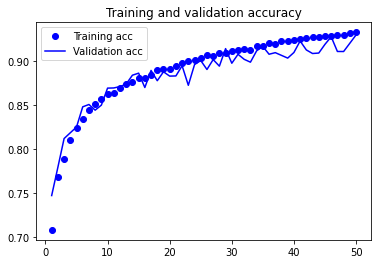

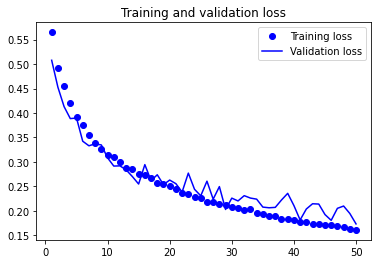

In [0]:
score1 = model.evaluate(X_test, y_test, verbose=2)
draw1(history, history1)

In [0]:
score1

[0.16758249926918, 0.9311836818790563]

In [0]:
save_model('bi_adam.h5')

In [0]:
history2 = model.fit(X_train, y_train, epochs=50, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)

Train on 62124 samples, validate on 15531 samples
Epoch 1/50
 - 50s - loss: 0.1615 - acc: 0.9331 - val_loss: 0.1900 - val_acc: 0.9242
Epoch 2/50
 - 49s - loss: 0.1593 - acc: 0.9333 - val_loss: 0.1663 - val_acc: 0.9319
Epoch 3/50
 - 50s - loss: 0.1581 - acc: 0.9340 - val_loss: 0.2116 - val_acc: 0.9156
Epoch 4/50
 - 49s - loss: 0.1596 - acc: 0.9342 - val_loss: 0.2040 - val_acc: 0.9181
Epoch 5/50
 - 48s - loss: 0.1523 - acc: 0.9362 - val_loss: 0.1707 - val_acc: 0.9314
Epoch 6/50
 - 49s - loss: 0.1527 - acc: 0.9364 - val_loss: 0.1707 - val_acc: 0.9336
Epoch 7/50
 - 49s - loss: 0.1496 - acc: 0.9385 - val_loss: 0.2725 - val_acc: 0.8871
Epoch 8/50
 - 49s - loss: 0.1514 - acc: 0.9373 - val_loss: 0.1701 - val_acc: 0.9297
Epoch 9/50
 - 50s - loss: 0.1475 - acc: 0.9388 - val_loss: 0.1809 - val_acc: 0.9278
Epoch 10/50
 - 52s - loss: 0.1476 - acc: 0.9392 - val_loss: 0.1514 - val_acc: 0.9413
Epoch 11/50
 - 52s - loss: 0.1422 - acc: 0.9405 - val_loss: 0.1747 - val_acc: 0.9303
Epoch 12/50
 - 51s - los

In [0]:
score2 = model.evaluate(X_test, y_test, verbose=2)

In [0]:
score2

[0.148495629652214, 0.9434428762748532]

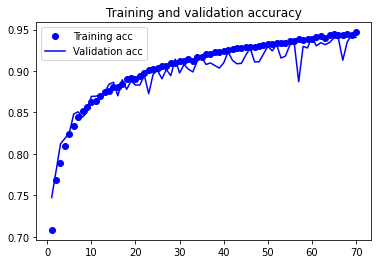

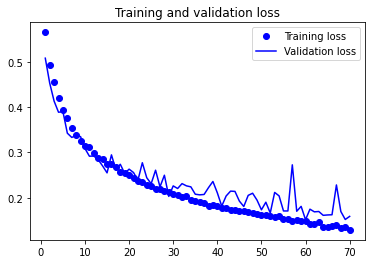

In [0]:
  acc = history.history['acc'] + history1.history['acc'] + history2.history['acc']
  val_acc = history.history['val_acc'] + history1.history['val_acc'] + history2.history['val_acc']
  loss = history.history['loss'] + history1.history['loss'] + history2.history['loss']
  val_loss = history.history['val_loss'] + history1.history['val_loss'] + history2.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [0]:
save_model('bi_adam_new.h5')

**model3**

In [0]:
# hyperparameter
TIME_STEP = 10
LSTM_OUTPUT_DIM = 64
BATCH_SIZE = 50
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156

In [0]:
KERNEL_SIZE = 3

In [0]:
%tensorflow_version 1.x
from keras.models import Model
from keras.layers import Input, Dense, concatenate, Activation, LSTM
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout

In [0]:
# def create_model():
#   lstm_model = Sequential()
#   lstm_model.add(Bidirectional(LSTM(64)))
#   lstm_model.add(Dropout(0.5))
  

#   conv_model = Sequential() 
#   conv_model.add(Conv1D(64, 8, padding='same', kernel_initializer = "he_uniform"))
#   conv_model.add(BatchNormalization())
#   conv_model.add(Activation('relu'))
#   conv_model.add(Conv1D(128, 5, padding='same', kernel_initializer = "he_uniform"))
#   conv_model.add(BatchNormalization())
#   conv_model.add(Activation('relu'))
#   conv_model.add(Conv1D(64, 8, padding='same', kernel_initializer = "he_uniform"))
#   conv_model.add(MaxPooling1D())

#   model = Sequential()
#   model.add(Merge([lstm_model, conv_model], mode='concat'))
#   model.add(Dense(INPUT_DIM))
#   model.add(Activation('softmax'))
#   model.add(Dense(1, activation='sigmoid'))

#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
#   return model

In [0]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 10, 64)            640       
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 64)            256       
_________________________________________________________________
activation_19 (Activation)   (None, 10, 64)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 8, 128)            24704     
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 128)            512       
_________________________________________________________________
activation_20 (Activation)   (None, 8, 128)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 6, 64)           

In [0]:
def create_model():
    ip = Input(shape = (TIME_STEP, INPUT_DIM))

    x = LSTM(8)(ip)
    x = Dropout(0.8)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding = "same", kernel_initializer = "he_uniform")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    y = Conv1D(256, 5, padding = "same", kernel_initializer = "he_uniform")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    y = Conv1D(128, 3, padding = "same", kernel_initializer = "he_uniform")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(1, activation = "softmax")(x)

    model = Model(ip, out)

    model.summary()

    return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

# create model
model = create_model()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10, 156)      0                                            
__________________________________________________________________________________________________
permute_3 (Permute)             (None, 156, 10)      0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 156, 128)     10368       permute_3[0][0]                  
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 156, 128)     512         conv1d_50[0][0]                  
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

Train on 62124 samples, validate on 15531 samples
Epoch 1/100
 - 30s - loss: 9.5517 - acc: 0.4009 - val_loss: 9.6582 - val_acc: 0.3942
Epoch 2/100
 - 29s - loss: 9.5517 - acc: 0.4009 - val_loss: 9.6582 - val_acc: 0.3942
Epoch 3/100


KeyboardInterrupt: ignored

In [0]:
score

NameError: ignored

In [0]:
draw(history)

In [0]:
save_model('lstm_fcn.h5')

draw figure

In [0]:
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

def draw1(history, history1):
  acc = history.history['acc'] + history1.history['acc']
  val_acc = history.history['val_acc'] + history1.history['val_acc']
  loss = history.history['loss'] + history1.history['loss']
  val_loss = history.history['val_loss'] + history1.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

Save model

In [0]:
MODEL_FOLDER = './drive/My Drive/636/model/'

In [0]:
def save_model(name):
  model.save(MODEL_FOLDER + name)

K fold

In [0]:
from sklearn.model_selection import StratifiedKFold
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define 4-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores = []
i = 0
for train, test in kfold.split(X, y):
  print('K-fold: %d\n' % i)
  i += 1
  model = create_model()
  history = model.fit(X[train], y[train], epochs=30, batch_size=50, 
                      validation_split=0.2, verbose=2, callbacks=callbacks_list)
  score = model.evaluate(X[test], y[test], verbose=2)
  scores.append(score)